## Redes Neurais Artificiais 2025.1

- **Disciplina**: Redes Neurais Artificiais 2025.1  
- **Professora**: Elloá B. Guedes (ebgcosta@uea.edu.br)  
- **Github**: http://github.com/elloa  

|Alunos                |Matrícula  |
|----------------------|-----------|
|Caio Bertoldo         |2215080050 |
|Danilo Jorge          |2215080007 |
|Diogo Gomes           |2215080033 |
|Guilherme Montenegro  |2215080011 |
|Leonardo Abinader     |2215080042 |
|Rodolfo Simões        |2215080073 |

### Tarefa de aprendizado

In [24]:
# Bibliotecas
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from joblib import Parallel, delayed, dump
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("datasets/updated_pollution_dataset_scaled.csv")
df.head()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality Encoded
0,-0.034080,-0.690715,-0.608589,-0.450455,-0.844581,-0.120721,0.402303,-0.588658,-1.168163,2
1,-0.257295,0.349507,-0.726706,-0.658892,0.493329,-0.046643,0.255775,-0.671748,0.743598,2
2,-1.031106,0.292768,0.267100,0.130973,-0.226219,0.383011,0.237459,-0.893318,0.795975,2
3,-0.435867,-1.951591,-0.571933,-0.874642,-1.451700,-0.698530,-0.641707,0.740767,0.350770,0
4,-0.525153,0.040593,-0.539349,-0.519934,-0.507293,-0.654083,-0.898130,1.183909,-1.272917,0


In [3]:
# Separação dos conjuntos
X = df.drop('Air Quality Encoded', axis=1)
y = df['Air Quality Encoded']

### Teste simples 1: MLP com solver Adam

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [5]:
# Testando MLP com solver Adam
mlp = MLPClassifier(
    hidden_layer_sizes=(10,),
    activation='relu',
    solver='adam',
    max_iter=300,
    verbose=True
)
mlp.fit(X_train, y_train)

Iteration 1, loss = 1.25172650
Iteration 2, loss = 1.16915424
Iteration 3, loss = 1.09278167
Iteration 4, loss = 1.02064647
Iteration 5, loss = 0.95329235
Iteration 6, loss = 0.89191396
Iteration 7, loss = 0.83752212
Iteration 8, loss = 0.78978754
Iteration 9, loss = 0.74872263
Iteration 10, loss = 0.71290728
Iteration 11, loss = 0.68174498
Iteration 12, loss = 0.65394486
Iteration 13, loss = 0.62874569
Iteration 14, loss = 0.60598606
Iteration 15, loss = 0.58520410
Iteration 16, loss = 0.56597873
Iteration 17, loss = 0.54786119
Iteration 18, loss = 0.53100227
Iteration 19, loss = 0.51500162
Iteration 20, loss = 0.49969025
Iteration 21, loss = 0.48504828
Iteration 22, loss = 0.47123015
Iteration 23, loss = 0.45768940
Iteration 24, loss = 0.44500768
Iteration 25, loss = 0.43271780
Iteration 26, loss = 0.42080659
Iteration 27, loss = 0.40926481
Iteration 28, loss = 0.39831719
Iteration 29, loss = 0.38795979
Iteration 30, loss = 0.37798135
Iteration 31, loss = 0.36821598
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(10,), max_iter=300, verbose=True)

In [7]:
# Desemepenho
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='weighted') * 100
recall = recall_score(y_test, y_pred, average='weighted') * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")

Accuracy: 94.33%
Precision: 94.29%
Recall: 94.33%
F1 Score: 94.27%


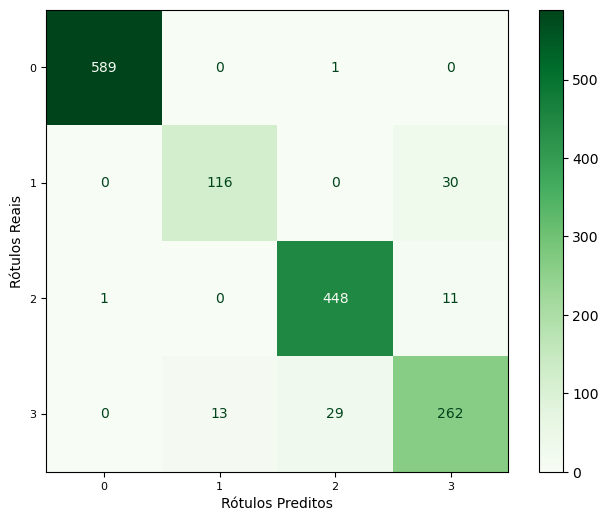

In [8]:
# Matriz de confusão
fig, ax = plt.subplots(figsize = (8, 6))

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax = ax, cmap = 'Greens')

ax.set_xlabel("Rótulos Preditos", fontsize = 10)
ax.set_ylabel("Rótulos Reais", fontsize = 10)

ax.tick_params(axis = 'both', labelsize = 8)

plt.show()

### Teste simples 2: MLP com solver SGD

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [10]:
# Testando MLP com solver SGD
mlp = MLPClassifier(
    hidden_layer_sizes=(10,),
    activation='relu',
    solver='sgd',
    max_iter=300,
    verbose=True
)
mlp.fit(X_train, y_train)

Iteration 1, loss = 1.74991804
Iteration 2, loss = 1.48588916
Iteration 3, loss = 1.26382078
Iteration 4, loss = 1.10501621
Iteration 5, loss = 0.99505176
Iteration 6, loss = 0.91807788
Iteration 7, loss = 0.86186285
Iteration 8, loss = 0.81914887
Iteration 9, loss = 0.78524947
Iteration 10, loss = 0.75711275
Iteration 11, loss = 0.73297058
Iteration 12, loss = 0.71169450
Iteration 13, loss = 0.69241724
Iteration 14, loss = 0.67498256
Iteration 15, loss = 0.65885304
Iteration 16, loss = 0.64389219
Iteration 17, loss = 0.63002415
Iteration 18, loss = 0.61694843
Iteration 19, loss = 0.60467023
Iteration 20, loss = 0.59295502
Iteration 21, loss = 0.58192736
Iteration 22, loss = 0.57139281
Iteration 23, loss = 0.56132969
Iteration 24, loss = 0.55171564
Iteration 25, loss = 0.54257714
Iteration 26, loss = 0.53378807
Iteration 27, loss = 0.52542051
Iteration 28, loss = 0.51746720
Iteration 29, loss = 0.50975877
Iteration 30, loss = 0.50238139
Iteration 31, loss = 0.49526729
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(10,), max_iter=300, solver='sgd',
              verbose=True)

In [11]:
# Desemepenho
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='weighted') * 100
recall = recall_score(y_test, y_pred, average='weighted') * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")

Accuracy: 92.67%
Precision: 92.55%
Recall: 92.67%
F1 Score: 92.60%


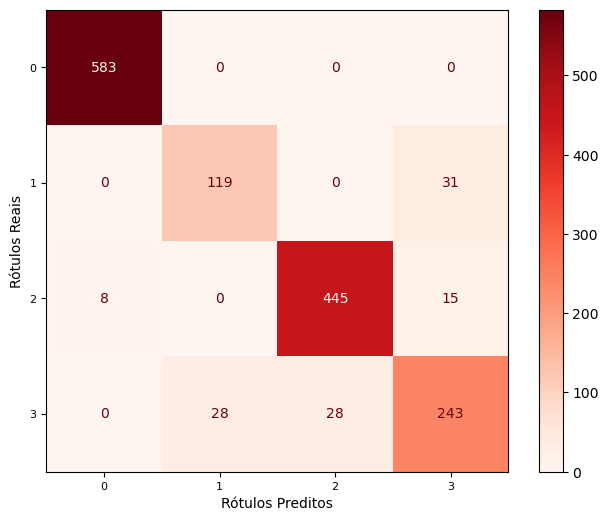

In [12]:
# Matriz de confusão
fig, ax = plt.subplots(figsize = (8, 6))

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax = ax, cmap = 'Reds')

ax.set_xlabel("Rótulos Preditos", fontsize = 10)
ax.set_ylabel("Rótulos Reais", fontsize = 10)

ax.tick_params(axis = 'both', labelsize = 8)

plt.show()

### Realizando 100 iterações de treinamento

In [13]:
def holdout_partition(X, y, test_size=0.3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    return X_train, X_test, y_train, y_test

In [ ]:
def treino_holdout_adam(X, y):
    X_train, X_test, y_train, y_test = holdout_partition(X, y)
    
    mlp = MLPClassifier(
    hidden_layer_sizes = (10,),     # 1 camada com 10 neurônios
    activation = 'relu',            # função de ativação ReLU
    solver = 'adam',                # solver Adam
    max_iter = 300,                 # 300 épocas
    verbose = False,                # sem passo a passo do treinamento
    )

    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average = 'weighted', zero_division = 0)
    return acc, f1

# Executar em paralelo (usa todos os núcleos disponíveis)
resultados_adam = Parallel(n_jobs = -1)(delayed(treino_holdout_adam)(X, y) for _ in range(100))

# Separar métricas
accs_adam, f1s_adam = zip(*resultados_adam)

In [15]:
print("Resultados - Adam (Treino)")
print(f"Acurácia - Média: {np.mean(accs_adam):.4f}, Desvio Padrão: {np.std(accs_adam):.4f}")
print(f"F1-Score - Média: {np.mean(f1s_adam):.4f}, Desvio Padrão: {np.std(f1s_adam):.4f}")

Resultados - Adam (Treino)
Acurácia - Média: 0.9420, Desvio Padrão: 0.0053
F1-Score - Média: 0.9417, Desvio Padrão: 0.0053


In [16]:
def treino_holdout_sgd(X, y):
    X_train, X_test, y_train, y_test = holdout_partition(X, y)
    
    mlp = MLPClassifier(
        hidden_layer_sizes = (10,),     # 1 camada com 10 neurônios
        activation = 'relu',            # função de ativação ReLU
        solver = 'sgd',                 # solver SGD
        max_iter = 300,                 # 300 épocas
        verbose = False,                # sem passo a passo do treinamento
    )
    
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average = 'weighted', zero_division = 0)

    return acc, f1

resultados_sgd = Parallel(n_jobs = -1)(delayed(treino_holdout_sgd)(X, y) for _ in range(100))

accs_sgd, f1s_sgd = zip(*resultados_sgd)

In [17]:
print("Resultados - SGD (Treino)")
print(f"Acurácia - Média: {np.mean(accs_sgd):.4f}, Desvio Padrão: {np.std(accs_sgd):.4f}")
print(f"F1-Score - Média: {np.mean(f1s_sgd):.4f}, Desvio Padrão: {np.std(f1s_sgd):.4f}")

Resultados - SGD (Treino)
Acurácia - Média: 0.9320, Desvio Padrão: 0.0064
F1-Score - Média: 0.9314, Desvio Padrão: 0.0066


In [18]:
if np.mean(accs_adam) > np.mean(accs_sgd):
    print("\nAdam obteve melhor desempenho médio que SGD.")
else:
    print("\nSGD obteve melhor desempenho médio que Adam.")

# Diferença clara?
print(f"Diferença média de acurácia: {np.mean(accs_adam) - np.mean(accs_sgd):.4f}")
print(f"Diferença média de F1-score: {np.mean(f1s_adam) - np.mean(f1s_sgd):.4f}")


Adam obteve melhor desempenho médio que SGD.
Diferença média de acurácia: 0.0101
Diferença média de F1-score: 0.0103


### Propondo novas arquiteturas

In [21]:
architectures = [(10, 20), (20,), (4, 8), (32, 16), (8, 16)]

functions = ['relu', 'logistic']

solvers = ['adam', 'sgd']

epochs = [100, 150, 200]

grid = list(product(architectures, functions, solvers, epochs))

In [29]:
def get_top3(overall_averages, grid):
    top3 = sorted(overall_averages, key = lambda av: (av[1], av[0]), reverse = True)[:3]

    print("\nTop-3 modelos por Acurácia e F1-score (médias):\n")

    for i, (f1, acc, idx, _, _) in enumerate(top3):
        print(f"Top {i + 1}: Arquitetura {idx} => Acurácia = {acc:.4f} | F1-score =  {f1:.4f} | Modelo = {grid[idx]}")

    return top3

In [25]:
# Função que gera os modelos de MLPClassifier com base na arquitetura passada como parâmetro, retornando os valores de acurácia de f1-score

def treino_e_avaliacao(X, y, arquitetura):
    X_train, X_test, y_train, y_test = holdout_partition(X, y)
    
    mlp = MLPClassifier(
        hidden_layer_sizes = arquitetura[0],
        activation = arquitetura[1],
        solver = arquitetura[2],
        max_iter = arquitetura[3],
        verbose = False
    )

    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average = 'weighted', zero_division = 0)
    cm = confusion_matrix(y_test, y_pred)

    return acc, f1, cm, y_test, y_pred, mlp

In [27]:
# Diretório onde os modelos serão salvos
os.makedirs("modelos_melhores_top60", exist_ok = True)

# Resultados detalhados para análise posterior
media_geral_arquiteturas = []
resultados_detalhados = []


for idx, model in enumerate(grid):
    print(f"Executando modelo {idx + 1}/{len(grid)}: {model}")

    resultados = Parallel(n_jobs = -1)(delayed(treino_e_avaliacao)(X, y, model) for _ in range(100))

    acuracias = [r[0] for r in resultados]
    f1_scores = [r[1] for r in resultados]

    # Melhor execução com base em F1 (desempate por acurácia)
    melhor_resultado = max(resultados, key = lambda r: (r[1], r[0]))
    acc, f1, cm, y_test, y_pred, mlp_model = melhor_resultado

    # Salvar o melhor modelo no disco
    nome_arquivo = f"modelos_melhores_top60/modelo_{idx:02d}_acc{acc:.4f}_f1{f1:.4f}.joblib"
    dump(mlp_model, nome_arquivo)

    media_acc = np.mean(acuracias)
    media_f1 = np.mean(f1_scores)
    desvio_acc = np.std(acuracias)
    desvio_f1 = np.std(f1_scores)

    acc_from_100, f1_from_100, cm, ytest_from_100, ypred_from_100, mlp_from_100 = zip(*resultados)

    # Armazenar resultados
    media_geral_arquiteturas.append((media_f1, media_acc, idx, desvio_f1, desvio_acc))
    resultados_detalhados.append({
        'modelo': model,
        'acuracia': acc,
        'f1_score': f1,
        'cm': cm,
        'y_test': y_test,
        'y_pred': y_pred
    })

Executando modelo 1/60: ((10, 20), 'relu', 'adam', 100)
Executando modelo 2/60: ((10, 20), 'relu', 'adam', 150)
Executando modelo 3/60: ((10, 20), 'relu', 'adam', 200)
Executando modelo 4/60: ((10, 20), 'relu', 'sgd', 100)
Executando modelo 5/60: ((10, 20), 'relu', 'sgd', 150)
Executando modelo 6/60: ((10, 20), 'relu', 'sgd', 200)
Executando modelo 7/60: ((10, 20), 'logistic', 'adam', 100)
Executando modelo 8/60: ((10, 20), 'logistic', 'adam', 150)
Executando modelo 9/60: ((10, 20), 'logistic', 'adam', 200)
Executando modelo 10/60: ((10, 20), 'logistic', 'sgd', 100)
Executando modelo 11/60: ((10, 20), 'logistic', 'sgd', 150)
Executando modelo 12/60: ((10, 20), 'logistic', 'sgd', 200)
Executando modelo 13/60: ((20,), 'relu', 'adam', 100)
Executando modelo 14/60: ((20,), 'relu', 'adam', 150)
Executando modelo 15/60: ((20,), 'relu', 'adam', 200)
Executando modelo 16/60: ((20,), 'relu', 'sgd', 100)
Executando modelo 17/60: ((20,), 'relu', 'sgd', 150)
Executando modelo 18/60: ((20,), 'relu'

In [31]:
# Mostra top-3 com matrizes
top3_resultados = get_top3(media_geral_arquiteturas, grid)


Top-3 modelos por Acurácia e F1-score (médias):

Top 1: Arquitetura 37 => Acurácia = 0.9470 | F1-score =  0.9467 | Modelo = ((32, 16), 'relu', 'adam', 150)
Top 2: Arquitetura 38 => Acurácia = 0.9467 | F1-score =  0.9465 | Modelo = ((32, 16), 'relu', 'adam', 200)
Top 3: Arquitetura 2 => Acurácia = 0.9453 | F1-score =  0.9450 | Modelo = ((10, 20), 'relu', 'adam', 200)



Top 1 - Modelo: ((32, 16), 'relu', 'adam', 150)
Melhor iteração - Acurácia: 0.9620, F1-Score: 0.9617


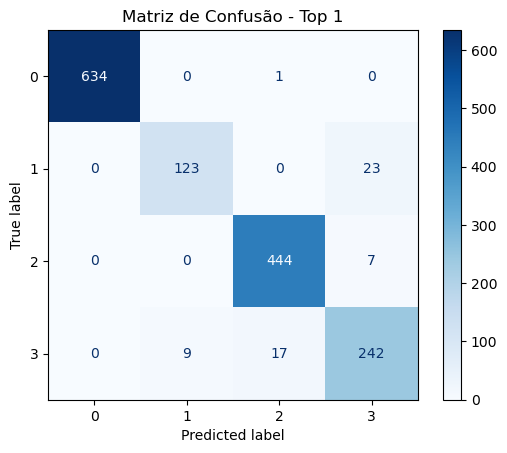


Top 2 - Modelo: ((32, 16), 'relu', 'adam', 200)
Melhor iteração - Acurácia: 0.9580, F1-Score: 0.9578


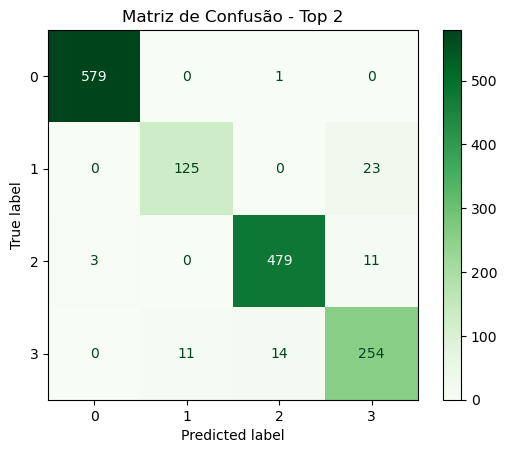


Top 3 - Modelo: ((10, 20), 'relu', 'adam', 200)
Melhor iteração - Acurácia: 0.9567, F1-Score: 0.9565


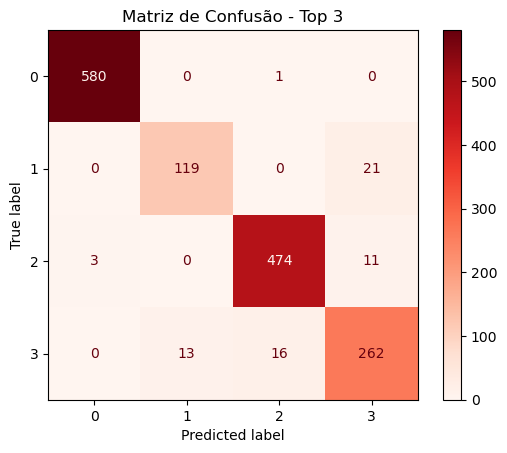

In [32]:
# Exibir matrizes de confusão para as 3 melhores
cmaps = ['Blues', 'Greens', 'Reds']

for i, (_, _, idx, _, _) in enumerate(top3_resultados):
    melhor = resultados_detalhados[idx]
    print(f"\nTop {i + 1} - Modelo: {melhor['modelo']}")
    print(f"Melhor iteração - Acurácia: {melhor['acuracia']:.4f}, F1-Score: {melhor['f1_score']:.4f}")
    disp = ConfusionMatrixDisplay.from_predictions(melhor['y_test'], melhor['y_pred'], cmap = cmaps[i])
    disp.ax_.set_title(f'Matriz de Confusão - Top {i + 1}')
    plt.show()

### Estimando número de neurônios

In [37]:
# Regra da Pirâmide Geométrica

alpha = [0.5, 1, 2]
n = round((X.shape[1] * 4)**0.5)
hn = [int(n*a) for a in alpha]
hn

[3, 6, 12]

In [41]:
architectures = [(3,), (3, 3), (12,), (4, 8), (9, 3)]

functions = ['relu', 'logistic', 'tanh']

solvers = ['adam', 'sgd']

epochs = [100, 150, 200]

grid2 = list(product(architectures, functions, solvers, epochs))

In [44]:
def treino_e_avaliacao_completo(X, y, arquitetura):
    X_train, X_test, y_train, y_test = holdout_partition(X, y)

    mlp = MLPClassifier(
        hidden_layer_sizes=arquitetura[0],
        activation=arquitetura[1],
        solver=arquitetura[2],
        max_iter=arquitetura[3],
        verbose=False
    )
    
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average = 'weighted', zero_division = 0)
    cm = confusion_matrix(y_test, y_pred)

    return acc, f1, cm, y_test, y_pred, mlp

In [45]:
# Diretório onde os modelos com NH serão salvos
os.makedirs("modelos_nh", exist_ok = True)

media_geral_nh = []  # (f1, acc, idx, std_f1, std_acc)
resultados_detalhados_nh = []  # salva os melhores modelos com y_test, y_pred e matriz

for j in range(len(grid2)):  
    print(f"\nExecutando arquitetura {j + 1}/{len(grid2)}: {grid2[j]}")

    # Paralelização das 100 iterações
    resultados = Parallel(n_jobs = -1)(
        delayed(treino_e_avaliacao_completo)(X, y, grid2[j]) for _ in range(100)
    )

    # Desempacotar os resultados
    acuracias = [r[0] for r in resultados]
    f1_scores = [r[1] for r in resultados]

    # Encontrar o melhor resultado (maior F1, desempate por acurácia)
    melhor_resultado = max(resultados, key=lambda r: (r[1], r[0]))

    media_acc = np.mean(acuracias)
    media_f1 = np.mean(f1_scores)
    std_acc = np.std(acuracias)
    std_f1 = np.std(f1_scores)

    # Armazena a média geral da arquitetura
    media_geral_nh.append((media_f1, media_acc, j, std_f1, std_acc))

    # Armazena o melhor caso completo para exibição posterior
    resultados_detalhados_nh.append({
        'arquitetura': grid2[j],
        'acuracia': melhor_resultado[0],
        'f1_score': melhor_resultado[1],
        'cm': melhor_resultado[2],
        'y_test': melhor_resultado[3],
        'y_pred': melhor_resultado[4]
    })

    # Salvar o melhor modelo
    nome_arquivo = f"modelos_nh/melhor_modelo_nh_{j:02d}.joblib"
    dump(melhor_resultado[5], nome_arquivo)


Executando arquitetura 1/90: ((3,), 'relu', 'adam', 100)

Executando arquitetura 2/90: ((3,), 'relu', 'adam', 150)

Executando arquitetura 3/90: ((3,), 'relu', 'adam', 200)

Executando arquitetura 4/90: ((3,), 'relu', 'sgd', 100)

Executando arquitetura 5/90: ((3,), 'relu', 'sgd', 150)

Executando arquitetura 6/90: ((3,), 'relu', 'sgd', 200)

Executando arquitetura 7/90: ((3,), 'logistic', 'adam', 100)

Executando arquitetura 8/90: ((3,), 'logistic', 'adam', 150)

Executando arquitetura 9/90: ((3,), 'logistic', 'adam', 200)

Executando arquitetura 10/90: ((3,), 'logistic', 'sgd', 100)

Executando arquitetura 11/90: ((3,), 'logistic', 'sgd', 150)

Executando arquitetura 12/90: ((3,), 'logistic', 'sgd', 200)

Executando arquitetura 13/90: ((3,), 'tanh', 'adam', 100)

Executando arquitetura 14/90: ((3,), 'tanh', 'adam', 150)

Executando arquitetura 15/90: ((3,), 'tanh', 'adam', 200)

Executando arquitetura 16/90: ((3,), 'tanh', 'sgd', 100)

Executando arquitetura 17/90: ((3,), 'tanh', 's

In [46]:
top3_nh = get_top3(media_geral_nh, grid2)


Top-3 modelos por Acurácia e F1-score (médias):

Top 1: Arquitetura 67 => Acurácia = 0.9410 | F1-score =  0.9406 | Modelo = ((4, 8), 'tanh', 'adam', 150)
Top 2: Arquitetura 68 => Acurácia = 0.9409 | F1-score =  0.9405 | Modelo = ((4, 8), 'tanh', 'adam', 200)
Top 3: Arquitetura 50 => Acurácia = 0.9407 | F1-score =  0.9404 | Modelo = ((12,), 'tanh', 'adam', 200)



Top 1 - Modelo: ((4, 8), 'tanh', 'adam', 150)
melhor_nh iteração - Acurácia: 0.9567, F1-Score: 0.9566


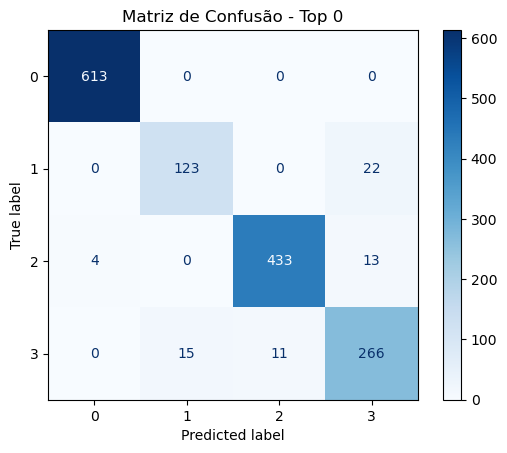


Top 2 - Modelo: ((4, 8), 'tanh', 'adam', 200)
melhor_nh iteração - Acurácia: 0.9653, F1-Score: 0.9652


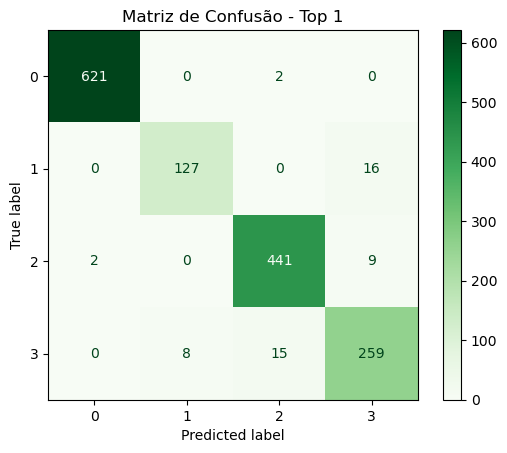


Top 3 - Modelo: ((12,), 'tanh', 'adam', 200)
melhor_nh iteração - Acurácia: 0.9520, F1-Score: 0.9519


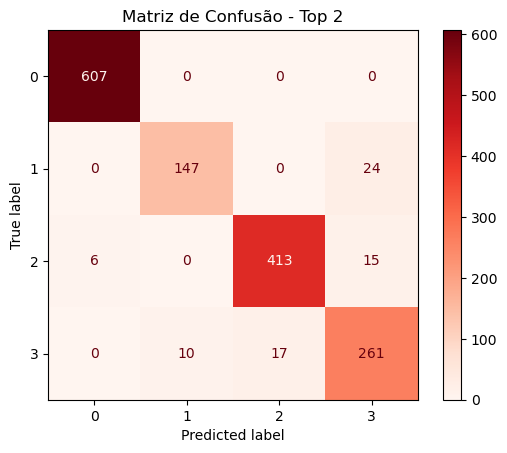

In [47]:
cmaps = ['Blues', 'Greens', 'Reds']

for i, (_, _, idx, _, _) in enumerate(top3_nh):
    melhor_nh = resultados_detalhados_nh[idx]
    print(f"\nTop {i + 1} - Modelo: {melhor_nh['arquitetura']}")
    print(f"melhor_nh iteração - Acurácia: {melhor_nh['acuracia']:.4f}, F1-Score: {melhor_nh['f1_score']:.4f}")
    disp = ConfusionMatrixDisplay.from_predictions(melhor_nh['y_test'], melhor_nh['y_pred'], cmap = cmaps[i])
    disp.ax_.set_title(f'Matriz de Confusão - Top {i}')
    plt.show()